# Load model, use it to evaluate test set, and save the model

- This notebook lets you load the best model obtained from hyperameter tuning
- The best model is currently chosen based on the criteria of best (lowest) val loss
- It is then used to evaluate the test set, and test accuracy will be computed
- The model will be saved to models/ folder where it will be used in FastAPI app

In [25]:
import sys
from pathlib import Path
import pickle
import torch
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to sys.path if it does not exist
project_root = Path().resolve().parents[0]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [3]:
# Define the directory using Path
ray_results_dir = project_root / "ray_results"

# Ensure the directory exists
ray_results_dir.mkdir(parents=True, exist_ok=True)

In [4]:
def load_best_model(ray_results_dir):
    """
    Load the best restnet50 model based on validation loss from Ray Tune results.

    Args:
        ray_results_dir (str or Path): Path to the Ray results directory.

    Returns:
        torch.nn.Module: The model loaded with the best checkpoint.
        dict: The configuration of the best trial.
    """
    ray_results_dir = Path(ray_results_dir)
    best_val_loss = float('inf')
    best_checkpoint_file = None
    best_config = None

    # Traverse experiments
    for experiment_dir in ray_results_dir.iterdir():
        if not experiment_dir.is_dir():
            continue  # Skip non-directory files like tuner.pkl

        # Traverse trials within each experiment
        for trial_dir in experiment_dir.iterdir():
            if not trial_dir.is_dir():
                continue  # Skip non-directory files

            # Traverse checkpoints within each trial
            for checkpoint_dir in trial_dir.glob("checkpoint_epoch_*"):
                if not checkpoint_dir.is_dir():
                    continue  # Skip non-directory files

                checkpoint_file = checkpoint_dir / f"{checkpoint_dir.name}.pkl"
                if not checkpoint_file.exists():
                    continue  # Skip if the checkpoint file doesn't exist

                # Load checkpoint data
                with open(checkpoint_file, "rb") as fp:
                    checkpoint_data = pickle.load(fp)

                # Check for val_loss
                if "val_loss" not in checkpoint_data:
                    print(f"Skipping {checkpoint_file}: 'val_loss' not found")
                    continue

                val_loss = checkpoint_data["val_loss"]
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_checkpoint_file = checkpoint_file
                    best_config = checkpoint_data["config"]

    if best_checkpoint_file is None:
        raise ValueError("No valid checkpoint with 'val_loss' found.")

    # Load the best checkpoint data
    with open(best_checkpoint_file, "rb") as fp:
        best_checkpoint_data = pickle.load(fp)

    # Initialize the resnet50 model
    model = models.resnet50(weights='DEFAULT')
    # Get input features of the fully connected layer
    num_ftrs = model.fc.in_features
    
    # Replace the fully connected layer with correct number of output classes
    model.fc = torch.nn.Linear(num_ftrs, best_config["num_classes"])

    model.load_state_dict(best_checkpoint_data["model_state_dict"])
    model.eval()  # prevents unintended train mode

    return model, best_config

In [5]:
best_model, best_config = load_best_model(str(ray_results_dir))

In [6]:
print("Best model loaded with config:", best_config)

Best model loaded with config: {'lr': 0.00023835124360836502, 'batch_size': 32, 'num_bottlenecks_to_unfreeze': 2, 'num_classes': 196, 'epochs': 15}


In [7]:
# View best model
best_model.type

<bound method Module.type of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ke

In [8]:
# Move model to device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
best_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
test_dir = project_root / "data" / "test"

In [18]:
test_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transformers)
test_loader = DataLoader(test_data, batch_size=best_config["batch_size"], shuffle=False, num_workers=4)

In [23]:
y_true, y_pred = [], []

best_model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

# Define criterion for loss computation (e.g., CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        loss = criterion(outputs, labels)
        test_loss += loss.item()


# Calculate metrics
test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test * 100

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=test_data.classes, columns=test_data.classes)

# Compute classification report
cr = classification_report(y_true, y_pred, target_names=test_data.classes)

Test Loss: 1.1162, Test Accuracy: 68.70%


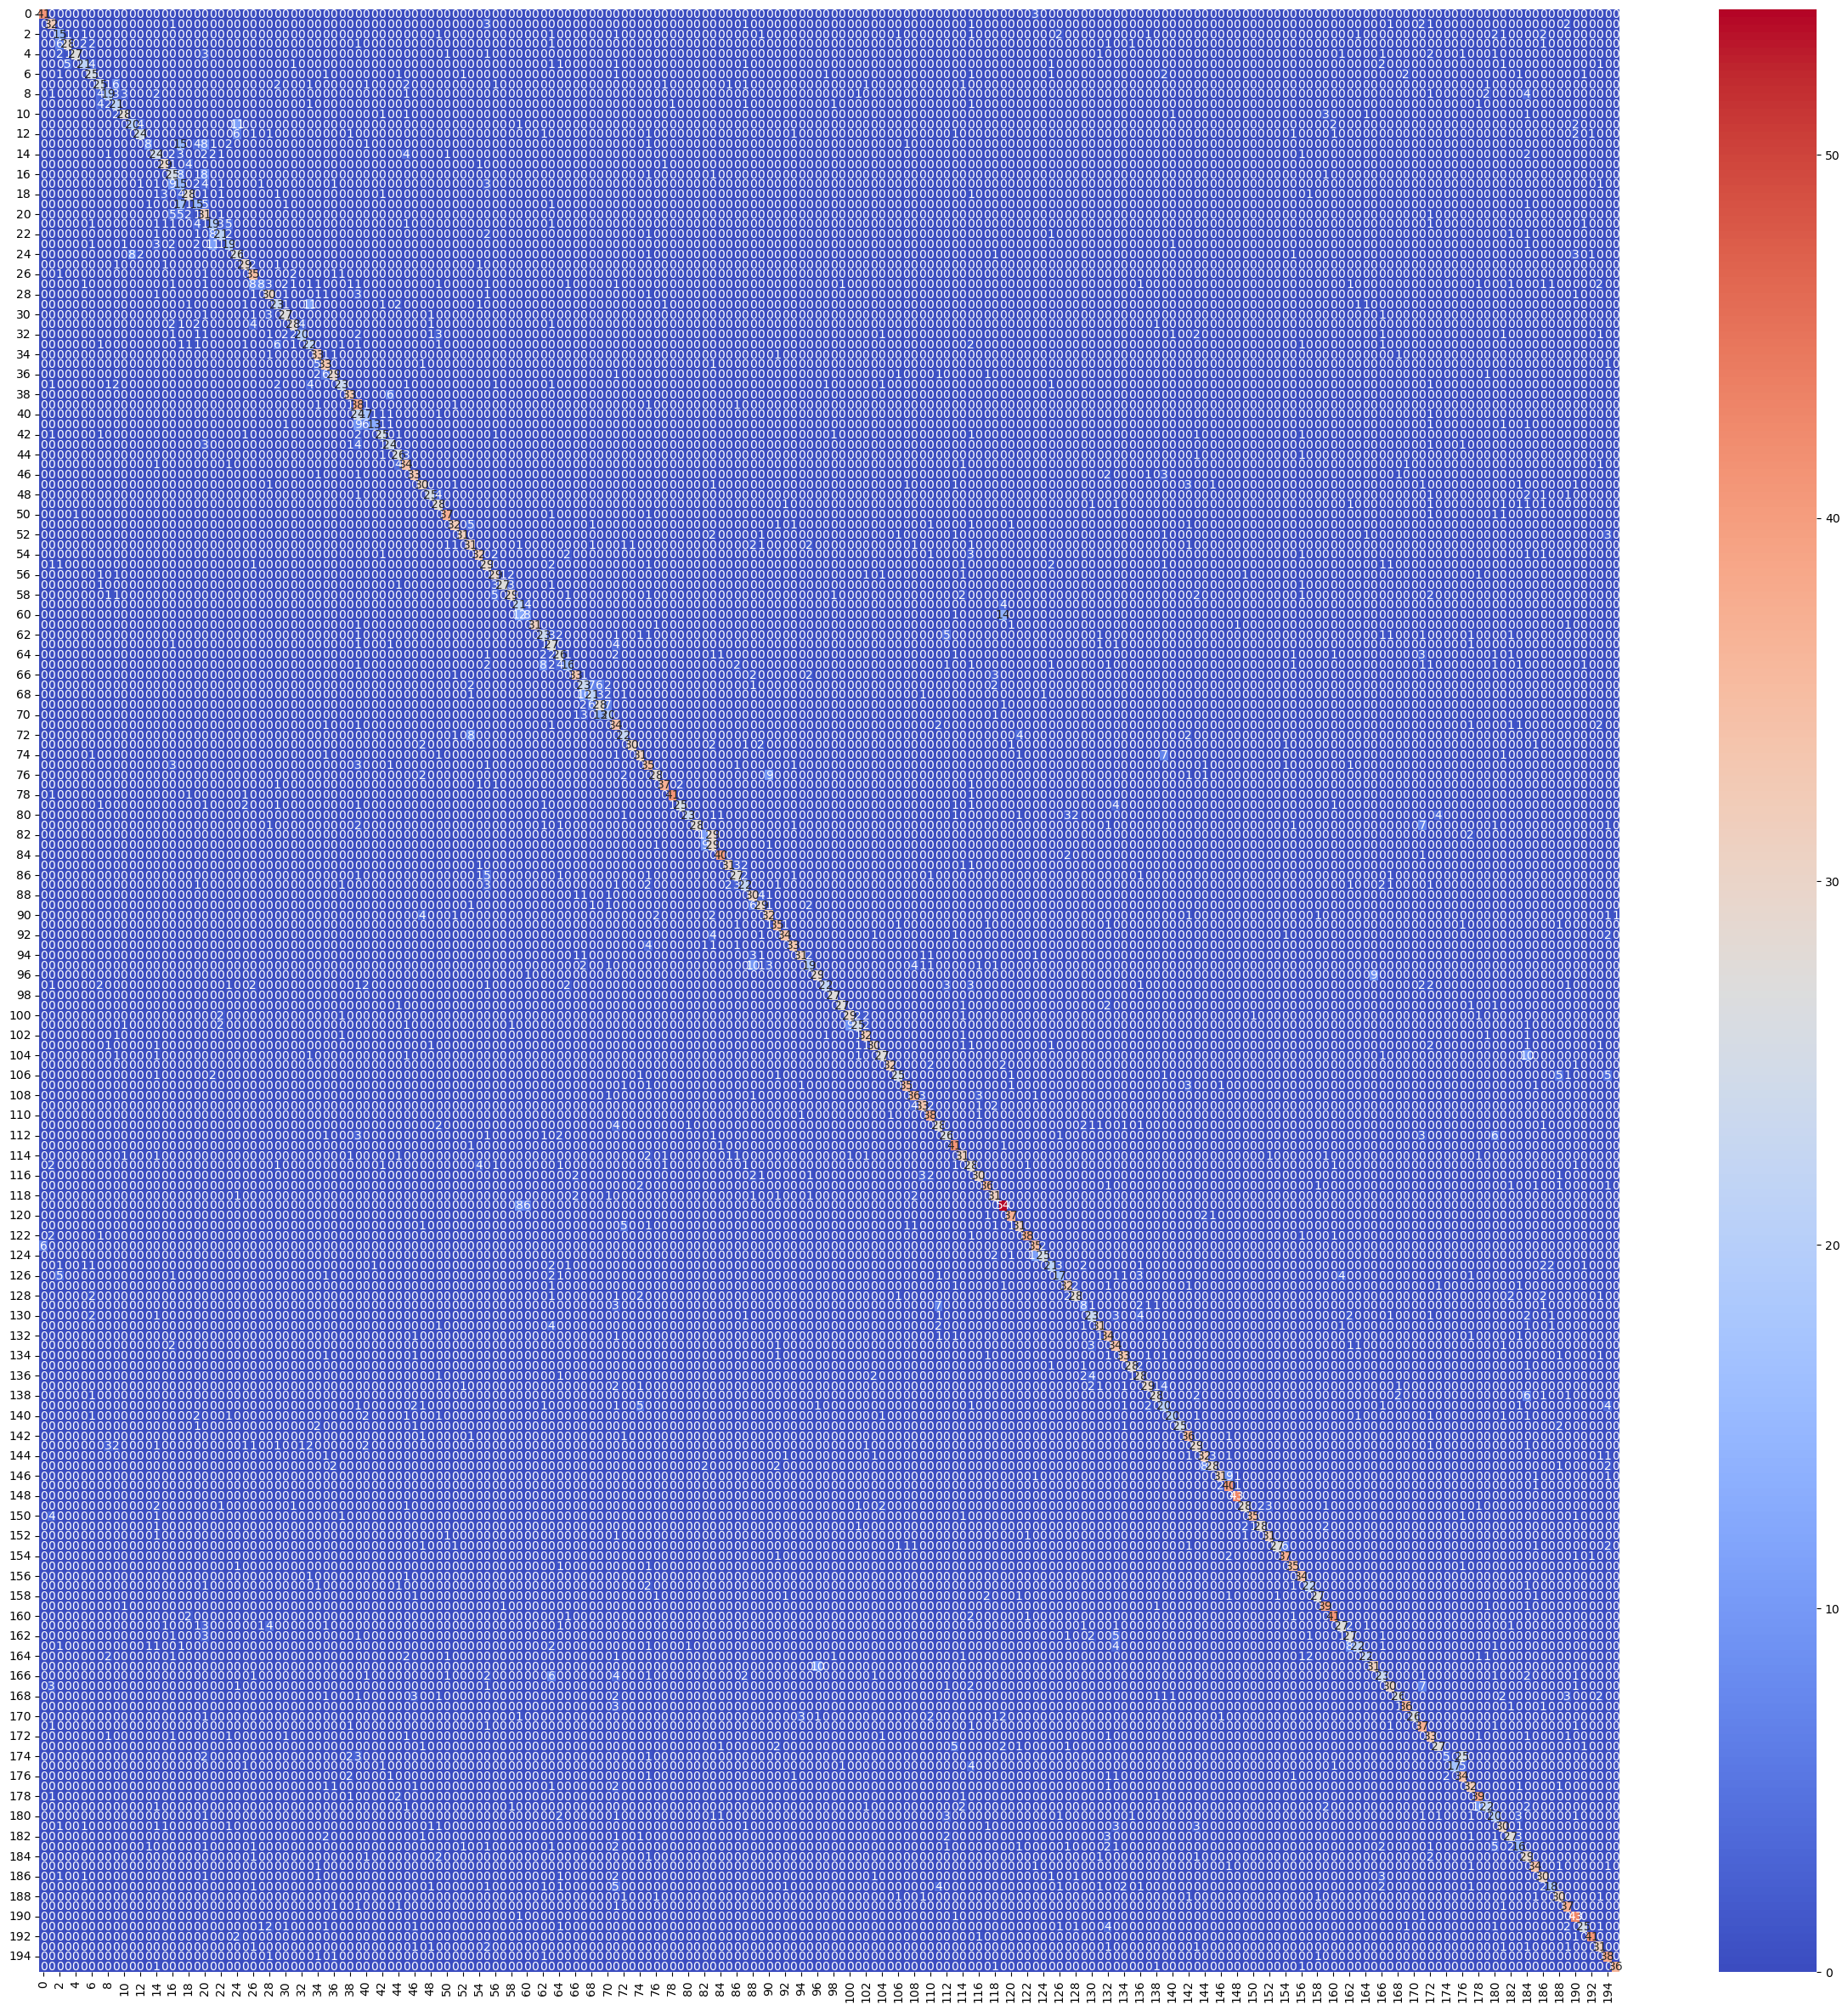

In [26]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm")
plt.show()

In [27]:
# Flatten the confusion matrix DataFrame into a long format for filtering
cm_long = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
cm_long = cm_long.rename(columns={'index': 'Actual'})

# Filter for misclassifications (Actual != Predicted) where the count is greater than 10
misclassified = cm_long[(cm_long['Actual'] != cm_long['Predicted']) & (cm_long['Count'] > 10)]

# Sort for better visibility
misclassified = misclassified.sort_values(by='Count', ascending=False)

# Display or save
print(misclassified)

                                            Actual  ... Count
16350                     Dodge Caliber Wagon 2007  ...    29
34670                 Rolls-Royce Ghost Sedan 2012  ...    25
7684             Bentley Continental GT Coupe 2007  ...    24
3351                            Audi S5 Coupe 2012  ...    17
3345                            Audi A5 Coupe 2012  ...    15
23384                   Chevrolet Express Van 2007  ...    14
13594  Chevrolet Silverado 2500HD Regular Cab 2012  ...    13
11624                   Chevrolet Express Van 2007  ...    12
4139                           Audi TTS Coupe 2012  ...    11
4715                           Audi 100 Sedan 1994  ...    11
6497                 BMW 6 Series Convertible 2007  ...    11
24232                     HUMMER H3T Crew Cab 2010  ...    11

[12 rows x 3 columns]


In [28]:
print(cr)

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.87      0.93      0.90        44
                             Acura Integra Type R 2001       0.63      0.73      0.67        44
                                   Acura RL Sedan 2012       0.43      0.47      0.45        32
                                   Acura TL Sedan 2012       0.80      0.65      0.72        43
                                  Acura TL Type-S 2008       0.96      0.64      0.77        42
                                  Acura TSX Sedan 2012       0.75      0.53      0.62        40
                              Acura ZDX Hatchback 2012       0.61      0.64      0.62        39
              Aston Martin V8 Vantage Convertible 2012       0.61      0.56      0.58        45
                    Aston Martin V8 Vantage Coupe 2012       0.59      0.46      0.52        41
                  Aston Martin Virage C

In [30]:
class_mapping = {idx: class_name for idx, class_name in enumerate(test_data.classes)}

In [31]:
# For saving model and class_mapping to models folder

save_models_dir = project_root / "models"
save_models_dir.mkdir(parents=True, exist_ok=True)

model_file_name = save_models_dir/ "best_resnet50_model.pth"
torch.save({"state_dict": best_model.state_dict(), "class_mapping": class_mapping}, str(model_file_name))

print(f"Model saved to {model_file_name}")

Model saved to /Users/jas/Documents/car-classification-api/models/best_restnet50_model.pth
